<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [30]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

дата содержится в первой колонке датасета: преобразуем в *datetime* и делаем её индексной

In [31]:
df = pd.read_csv('taxi.csv',
                 parse_dates=[0],
                 index_col=[0])

## Анализ

In [32]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверяем индекс на монотонность

In [33]:
df.index.is_monotonic

True

Данные приведены с периодом 10 минут, проведём ресемплирование по одному часу, просуммировав заказы

In [34]:
df = df.resample('1H').sum()

Разложим временной ряд на тренд, сезонную составляющую и остатки. Отобразим их графики

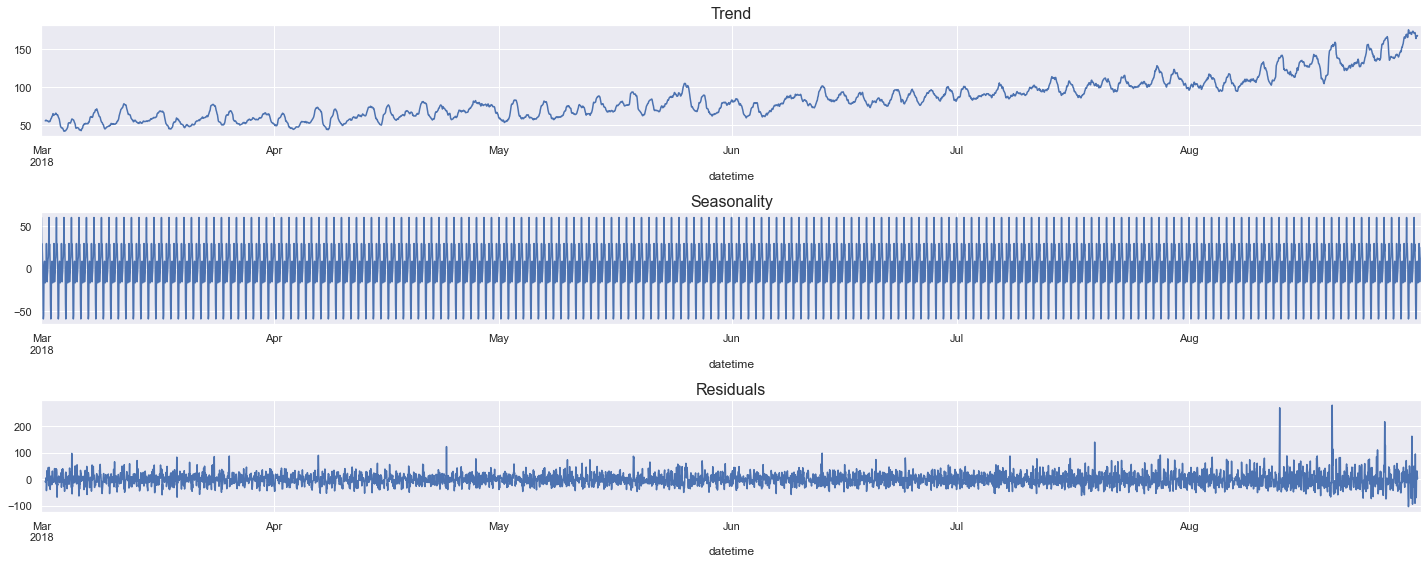

In [35]:
decomposed = seasonal_decompose(df.num_orders)

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', size=16)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', size=16)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals', size=16)

plt.tight_layout()

- Наблюдается постепенное увеличение количества заказов с небольшими колебаниями на протяжении всего имеющегося периода 
- чётко прослеживается сезонность, скорее всего привязанная к активности людей в течение суток, ниже построим график только за несколько дней, чтобы рассмотреть лучше

<AxesSubplot:xlabel='datetime'>

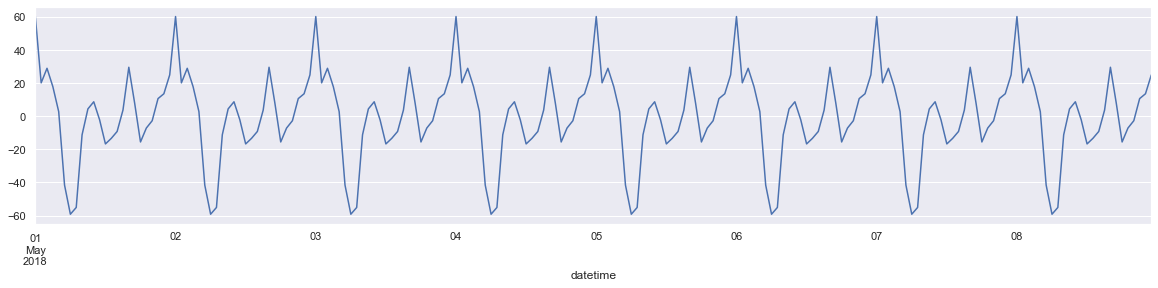

In [36]:
decomposed.seasonal['2018-05-01':'2018-05-08'].plot(figsize=(20, 4))

Проверяем стационарность ряда (Расширенный тест Дики — Фуллера)
- Нулевая гипотеза: ряд не стационарен
- Альтернативная: ряд стационарен

In [37]:
test_stat, p_val, _, _, crit_val, _ = sts.adfuller(df.num_orders)

In [38]:
test_stat

-3.0689242890279274

In [39]:
p_val

0.028940051402615206

In [40]:
crit_val

{'1%': -3.431842162413052,
 '5%': -2.8621993540813637,
 '10%': -2.567120978470452}

p-значение меньше 0.05, значение статистики меньше критических на 5% и 10% уровнях значимости: нулевую гипотезу можно отвергнуть и признать ряд стационарным

Построим диаграммы функций автокорреляции и частной автокорреляции, возьмем количество лагов равное 24*7 = 168

<function matplotlib.pyplot.show(close=None, block=None)>

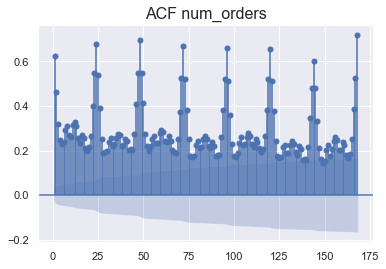

In [41]:
sgt.plot_acf(df.num_orders,  lags = 168, zero = False)
plt.title('ACF num_orders', size = 16)
plt.show

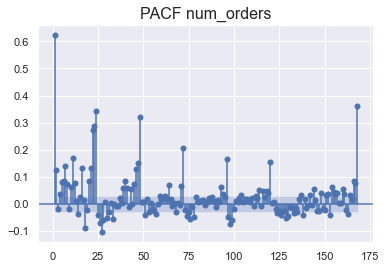

In [42]:
sgt.plot_pacf(df.num_orders, lags = 168, zero = False, method= ('ols'))
plt.title('PACF num_orders', size = 16)
plt.show()

Графики показывают, что значение, за выбранный период сильно взаимосвязано со значением за предыдущий период, а так же коррелирует со значениями за сутки и т.д. вплоть до недели назад

## Подготовка данных

Зададим функцию для создания дополнительных признаков: календарных, отстающих значений скользящего среднего; и разделения на обучающую и тестовую выборки

отстающие значения добавляем за предыдущий период, затем за сутки и т.д вплоть до 168 часов

In [43]:
def make_features(data, rolling_mean_size):
    df = data.copy()
    
    df.columns = ["y"]

    df['lag_1']=df.y.shift(1)
    #df['lag_2']=df.y.shift(1)
    for i in range(24, 169, 24):
        df["lag_{}".format(i)] = df.y.shift(i)
       
    df['rolling_mean'] = df['y'].shift().rolling(rolling_mean_size).mean()
    df["hour"] = df.index.hour
    df["weekday"] = df.index.weekday
    df['is_weekend'] = df.weekday.isin([5,6])*1
    
    return df

Выбираем размер скользящего окна 24 часа, создаём набор данных с новыми признаками и отделяем целевой

In [44]:
with_features = make_features(df, 24)
X = with_features.drop(columns = 'y')
y = with_features.y

Разбиваем на обучающую и тестовую выборки

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)

In [46]:
X_train.dropna().index[0]

Timestamp('2018-03-08 00:00:00', freq='H')

In [47]:
X_train = X_train.dropna()

In [48]:
y_train = y_train.loc['2018-03-08 00:00:00':]

Отстающие значения - численные признаки, их стандартизируем

In [49]:
num_cols = [x for x in with_features.columns if x.startswith('lag') ]

In [50]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])

## Обучение

Для обучения выберем несколько моделей:
- Случайный лес
- LightGMB
- Гребневую регрессию
- Лассо

Для каждой модели зададим некоторое поле параметров для перебора GridSearchCV

Переберём модели, сохраним результаты кросс-валидации и лучшую модель

In [ ]:
models = [RandomForestRegressor(random_state=42),
          LGBMRegressor(random_state=42),
          Ridge(random_state=42),
          Lasso(random_state=42)
         ]

param_grid = [{'n_estimators': [50, 100, 200],
             'max_depth': [5, 10, 15]},
              
              {'max_depth': [2, 4, 8],
               'num_leaves': [2, 4, 8],
               'learning_rate': [0.05, 0.1, 0.5]},
              
              {'alpha': np.logspace(0,3,4)},
              
              {'alpha': np.logspace(0,3,4)}]

cv = TimeSeriesSplit(n_splits=8)
results = []
best_score = 10000
best_model = None
for i, model in enumerate(models):
    grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid[i],
                          cv = cv,
                          scoring = 'neg_mean_squared_error')
    result = grid_search.fit(X_train, y_train)
    cv_results = pd.DataFrame(result.cv_results_)[['mean_test_score',
                                                   'std_test_score',
                                                   'mean_fit_time',
                                                   'mean_score_time',
                                                   'rank_test_score']]
    cv_results['Model'] = str(model).split('(')[0]
    cv_results['RMSE'] = np.sqrt(abs(cv_results['mean_test_score']))
    if cv_results['RMSE'].min() < best_score:
        best_score=cv_results['RMSE'].min()
        best_model = result.best_estimator_
    results.append(cv_results)

In [52]:
pd.concat([result for result in results], axis=0).sort_values(by='RMSE', ascending = True).reset_index(drop=True)


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,rank_test_score,Model,RMSE
0,-490.330146,156.409639,0.002743,0.001247,1,Ridge,22.143400
1,-491.467774,155.312124,0.003493,0.001993,2,Ridge,22.169072
2,-492.224773,154.742698,0.003492,0.001870,3,Ridge,22.186139
3,-494.350793,158.408860,0.003500,0.001112,1,Lasso,22.234001
4,-511.129281,170.713101,0.553390,0.009848,1,RandomForestRegressor,22.608168
5,-511.454616,169.622700,1.133972,0.018572,2,RandomForestRegressor,22.615362
6,-513.513175,167.061070,0.014960,0.002119,1,LGBMRegressor,22.660829
7,-514.659182,170.092612,0.273022,0.005358,3,RandomForestRegressor,22.686101
8,-515.386162,169.395100,1.445701,0.020575,4,RandomForestRegressor,22.702118
9,-515.618115,170.129774,0.737155,0.011094,5,RandomForestRegressor,22.707226


После кросс-валидации с перебором гиперпараметров три лучших результата у Гребневой регрессии.<br>
Параметры модеди с лучшим результатом ниже

In [53]:
best_model

Ridge(alpha=100.0, random_state=42)

## Тестирование

Проверим модель на тестовой выборке

In [54]:
predictions = best_model.predict(X_test)
print("RMSE на тестовой выборке", np.sqrt(mean_squared_error(y_test, predictions)))

RMSE на тестовой выборке 34.62030022090136


Рубеж в 48 заказов успешно пройден

## Вывод

Имеющийся временной ряд был ресемплирован по одному часу.

При декомпозиции обнаружена явная сезонность с периодом в 1 сутки, графики автокорреляции намекают также на вторичную сезонность с периодом в неделю.

По результатам расширенного теста Дики-Фулера временной ряд можно с натяжкой признать стационарным (критическое значение для 1% уровня значимости -3.43 меньше результата теста -3.06). Возможно, нужно дифферинцировать ряд

Для прогнозирования были добавлены дополнительные признаки: отстающие значения вплоть до недели, скользящее среднее за сутки и календарные: рабочий/нерабочий день, час, день недели

Набор разбит на обучающую и тестовую выборки. Обучено и проверено путём кросс-валидации с перебором параметров несколько моделей, из которых лучше всего себя показала Гребневая регрессия с коэффициентом регуляризации *alpha* равным 10: среднее RMSE - 22.9

На тестовой выборке результат хуже: 34.85. Но бейслайн в 48 заказов преодолён. Ухудшение результата скорее всего связано с тем, что в качестве тестовой выборки использовались последние 10% ряда, а как показали графики декомпозиции временного ряда, ближе к концу он наименее стационарен